<i> I go over how to use R to harvest information from web pages. This post chronicles my use of rvest to harvest movie information from Rotten Tomatoes to explore the difference between professional critics and general audiences. </i>
<!--TEASER_END-->

 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="#The-Problem" data-toc-modified-id="The-Problem-1">The Problem</a></span></li><li><span><a href="#Getting-the-Data" data-toc-modified-id="Getting-the-Data-2">Getting the Data</a></span><ul class="toc-item"><li><span><a href="#Getting-Started" data-toc-modified-id="Getting-Started-2.1">Getting Started</a></span></li><li><span><a href="#Scraping-Our-First-Page" data-toc-modified-id="Scraping-Our-First-Page-2.2">Scraping Our First Page</a></span></li><li><span><a href="#Scraping-with-httr-and-Regular-Expressions" data-toc-modified-id="Scraping-with-httr-and-Regular-Expressions-2.3">Scraping with httr and Regular Expressions</a></span></li><li><span><a href="#Extracting-Movie-Info-From-Rotten-Tomatoes" data-toc-modified-id="Extracting-Movie-Info-From-Rotten-Tomatoes-2.4">Extracting Movie Info From Rotten Tomatoes</a></span></li></ul></li><li><span><a href="#Data-Cleaning-&amp;-Exploration" data-toc-modified-id="Data-Cleaning-&amp;-Exploration-3">Data Cleaning &amp; Exploration</a></span><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-3.1">Data Cleaning</a></span></li><li><span><a href="#Preliminary-Questions" data-toc-modified-id="Preliminary-Questions-3.2">Preliminary Questions</a></span></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-3.3">Data Exploration</a></span></li></ul></li></ul></div>

# The Problem

<p> Recently, I was reading this <a href="https://www.vanityfair.com/hollywood/2017/03/brett-ratner-rotten-tomatoes"> article</a>, which mentions some of Hollywood's discontent for Rotten Tomatoes. This made me wonder how useful critic scores are for the average person. That is to say, do critics and general audiences generally feel the same way about movies, or is there actually a large disconnect between audiences and professional critics? After all, it is possible that professional movie critics and your average movie goer are looking for completely different things; in which case, a critic's opinion may only be useful to people who think like critics. </p>

<p>After thinking about it, I decided that a review aggregator like Rotten Tomatoes would be perfect for answering my question, since the website has already compiled statistics on profession movie reviews, but also has a large number of user-generated reviews. So I will use R to scrape movie data from Rotten Tomatoes to answer my question. (I probably could get the same information by using the API, but I really wanted to learn how to scrape a website for data.) </p>


# Getting the Data

<p><i>To create a better user experience, I have made various versions of my data set available for download. That way you can run a snippet of code without actually having to scrape web pages,which can be time intensive.</i> </p>

## Getting Started

In [1]:
#Required Libraries.
library(rvest)
library(httr)
library(ggplot2)
library(reshape2)


Loading required package: xml2


<p>I will be using the rvest library since it has a clean and compact design, easy to use selectr tools, and the magittr functionality allows you to write very elegant code. (Magittr allows you to use "%>%" to push an object forward to the next function, allowing you to write code with fewer named arguments.) I learned how to use rvest by reading this <a href="https://www.analyticsvidhya.com/blog/2017/03/beginners-guide-on-web-scraping-in-r-using-rvest-with-hands-on-knowledge/">tutorial</a>, but I will also thoroughly describe the steps I took in using it. </p>

<p>Because we are creating our own data, our first step is to decide what data we want and how we should get it. The easiest option would be to just look at the <a href="https://www.rottentomatoes.com/top/bestofrt/">"Top 100"</a> lists for each genre on Rotten Tomatoes and copy the tables. However, that would limit my exploration to movies that are highly critically acclaimed. And while that focused approach could have value, I'd rather look at a broader set of movies. Instead, I decide that I will try to scrape movie information for all movies made in the last 10 years. Unfortunately, Rotten Tomatoes doesn't order its movies by year, which means I have to jump through a few hoops to get my desired data set. As a workaround, I will be using Wikipedia to generate a list of movies created in the last 10 years, since Wikipedia has a fairly comprehensive list of movies released for every calendar year.</p>

## Scraping Our First Page 

Now that I know what I want to do, I will create a list of pages to scrape. Since all of the pages I want to scrape follow a pattern, I can use the paste command to generate my list of URLs.

In [ ]:
WikipediaURLs = paste("https://en.wikipedia.org/wiki/", 2006:2016, "_in_film", sep = "")

<p>For each page in my list, I will use "read_html" to convert the web page into an R data frame. I then use "html_nodes" to specify the exact xpath or <a href="https://www.w3schools.com/cssref/css_selectors.asp">css selector</a> I want. If you are unfamiliar with what a css selector or xpath is, they are essentially ways to specify the location of an object within an html document. I generally find css selectors easier to work with, but xpaths seem to work better with Jupyter notebooks.</p>

The <a href="https://www.analyticsvidhya.com/blog/2017/03/beginners-guide-on-web-scraping-in-r-using-rvest-with-hands-on-knowledge/">tutorial</a> I linked to earlier advises you to use the <a href="http://selectorgadget.com/">SelectorGadget</a> extension on Chrome to figure out the xpath or css selector that you want to use, but I found the SelectorGadget to be pretty finicky. I found it easier to use the inspect element tool available on most browsers: With this method, you right click on the element you want to extract and click "inspect." You should see the corresponding html code appear highlighted on the right. Right click on the highlighted html code and choose copy xpath or copy selector as desired. This will give you the exact path for the specific element you clicked on. You can then generalize or narrow that path as appropriate. Bellow you can see pictures of me doing this for the Wikipedia pages I am scraping.</p> 


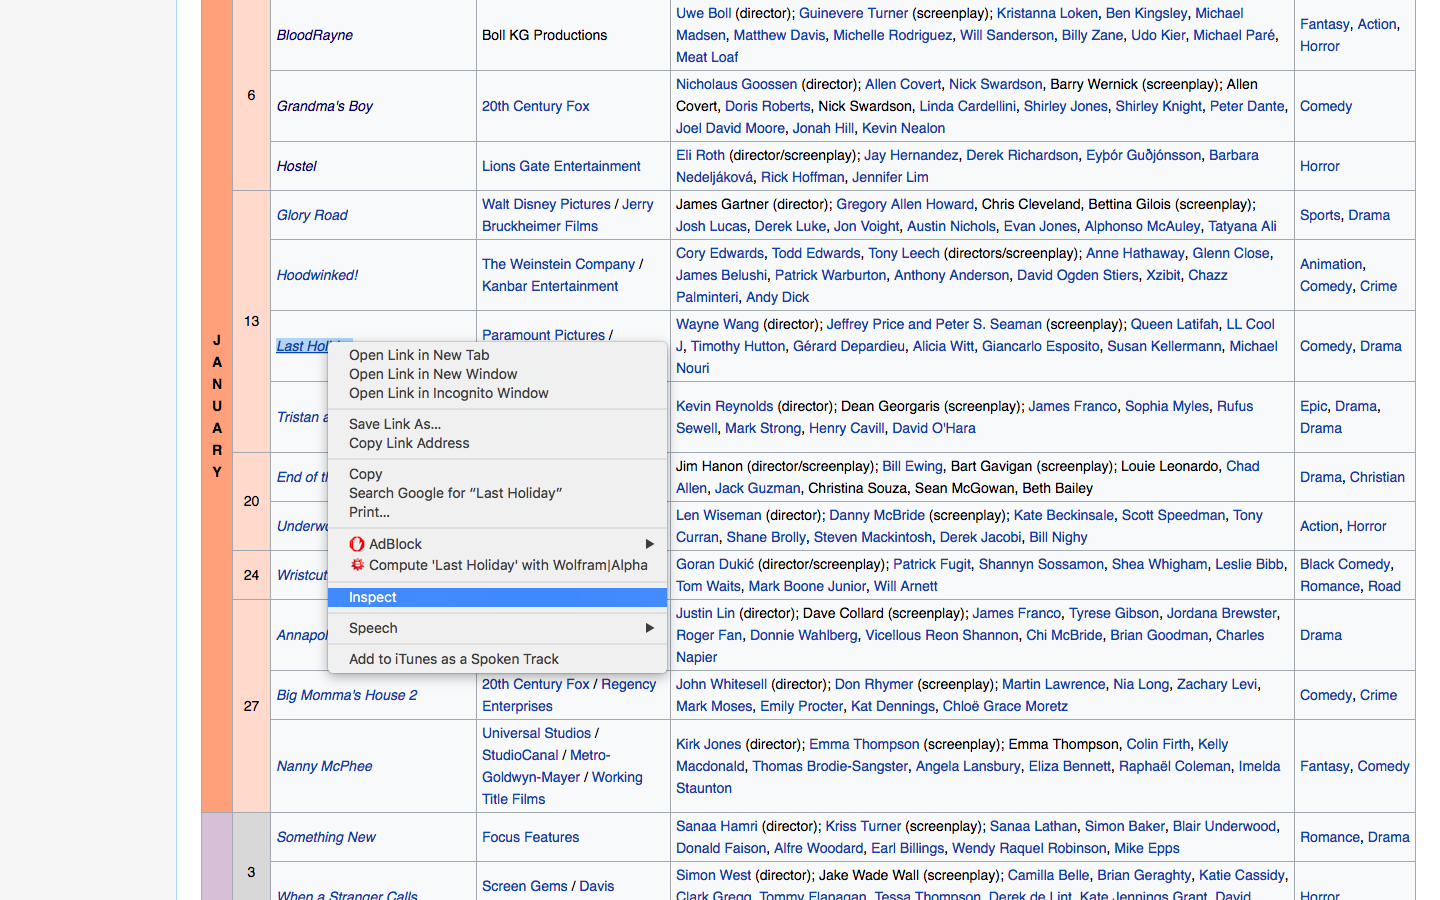

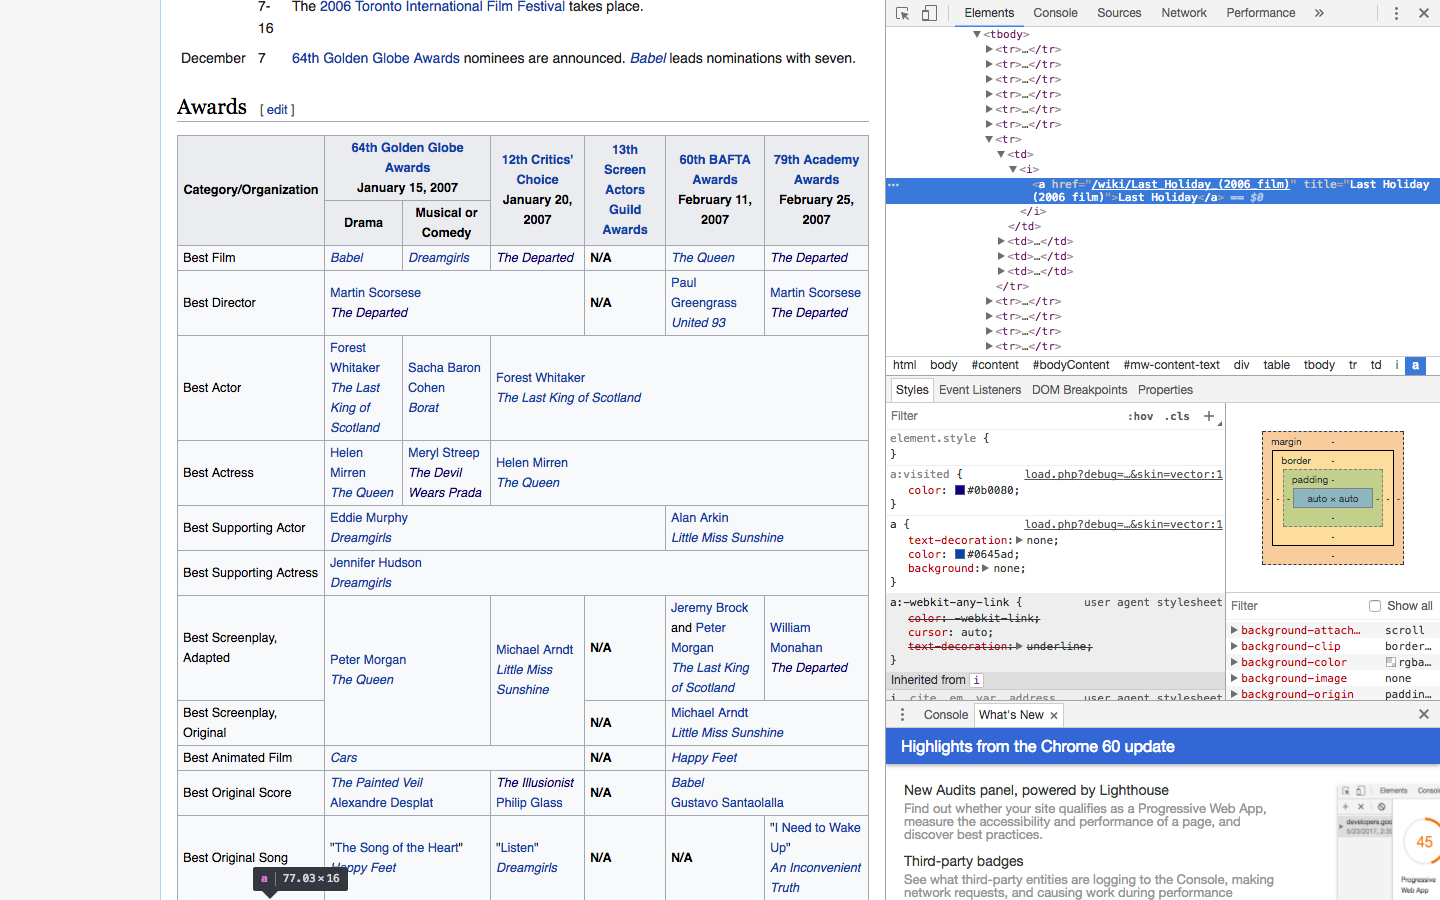

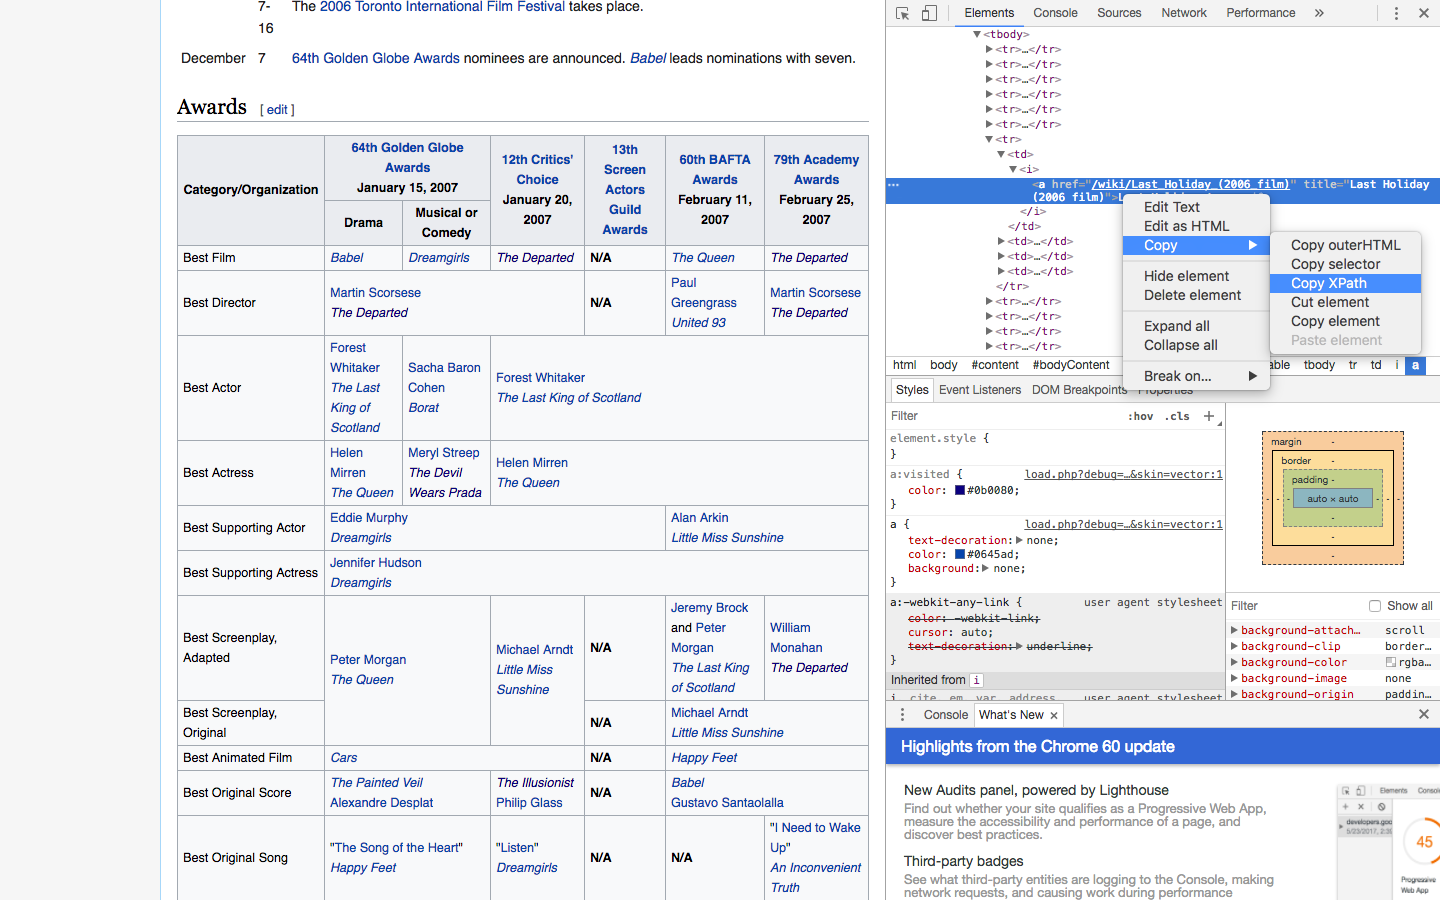



<p>You can further specify which elements you want by using "html_attr" which gives you the contens of a single attribute. For instance, here I use the html_attr function to specify that I only care about the "title" attribute.</p>

In [ ]:
Titles = lapply(WikipediaURLs, function(i) {
    read_html(i) %>% html_nodes(xpath = "//*[contains(concat( \" \", @class, \" \" ), concat( \" \", \"wikitable\", \" \" ))]//i//a") %>% 
        html_attr("title")
})

Titles = unlist(Titles)

<p>The code above gives me the list of movie titles I wanted. Unfortunately, converting that list of titles into a list of Rotten Tomatoes URLs was harder than I anticipated. Initially I thought I create a rule to turn a title into a URL or use Rotten Tomoatoes' search function to generate my list of URLs. But I could find no such rule, and Rotten Tomatoes' search function has wasn't robust enough to do the job.</p>

<p>I then tried to obtain a list of Rotten Tomatoes URLs by automating a Google search of Rotten Tomatoes + {movie title} and harvesting the top result. But as I later discovered, Google has protections in place to keep people from doing just this kind of thing (though people do get around it). At the end of the day, I decided that it was too impractical to write a scraping script that didn't get flagged down by Google, and that I should look for a better solution. After taking a break from the problem, I realized that most of Wikipedia's movie pages have an <i>External Links</i> section that contain links to movie's Rotten Tomatoe's page. So all I had to do was get a list of individual Wikipedia movie pages, and harvest each page's <i>External Links</i> section to get what I want. </p>

<p> The process for generating a list of Wikipedia movie pages is the same as generating a list of movie titles, except now I care about the "href" attribute instead of the "title" attribute. So I can reuse my code from the previous section. </p>


In [ ]:
Links = lapply(WikipediaURLs, function(i) {
    read_html(i) %>% html_nodes(xpath = "//*[contains(concat( \" \", @class, \" \" ), concat( \" \", \"wikitable\", \" \" ))]//i//a") %>% 
        html_attr("href")
})

Links = unlist(Links)

<p>I then combine my list of titles and URLs into a single dataframe and use the "unique" function to eliminate redundant links.</p>

In [ ]:
MovieTable = data.frame(Title = Titles, WikipediaLink = paste("https://en.wikipedia.org", Links, sep = ""), stringsAsFactors = FALSE)
MovieTable = unique(MovieTable)

## Scraping with httr and Regular Expressions

 <p> The first time I tried to scrape the links in my data frame, I ran into the following problem: some of the links I had collected in the previous step were invalid. This meant that the "read_html" command would try in vain to load a web page until it timed out, generating an error. To fix this, I used the httr library, which allows me to use the "GET" command to create a response summary for a URL. If the URL is unresponsive, this will show up in the response summary. I can then tell my code not to run on pages that generate a connection error (status code above 300), so that my code doesn't time out.</p>
 <p>I faced another issue when trying to extract Rotten Tomatoes links from Wikipedia, I couldn't get enough specificity from css selectors and attributes alone. CSS selectors allowed me to specify that I only wan elements in the <i>External Links</i> section of the Wikipedia page, and html attributes allowed me to specify that of those elements I only want external links; but that still left me with a lot of non-Rotten Tomatoes external links. To get around this, I used regular expressions to filter out any element that didn't contain the "https://www.rottentomatoes.com/m" substring, since I know that I am only interested in links that contain this domain. </p>


In [ ]:
MovieTable$RottenTomatoesLink = NA

for (i in seq(nrow(MovieTable))) {
    Connection = GET(MovieTable$WikipediaLink[i]) 
    if (status_code(Connection) <= 300) { #skip over pages that have a connection error
        Link = read_html(MovieTable$WikipediaLink[i]) %>% html_nodes(xpath = "//*[@id=\"mw-content-text\"]/div/ul/li/a") %>% 
            html_attr("href")
        
        Link = grep("https://www.rottentomatoes.com/m", Link, value = TRUE)
        if (length(Link) == 0) {
            Link = NA_character_
        }
        
        MovieTable$RottenTomatoesLink[i] = Link
    }
}

<p>Now to check my results. </p>

In [ ]:
load('RottenTomatoesLinks.Rda')
head(MovieTable)

In [ ]:
sum(is.na(MovieTable$RottenTomatoesLink))
str(MovieTable)

<p> Even though my code was successful, it appears that 715 out of 2873 Wikipedia pages that I scraped were either invalid or had no link to a Rotten Tomatoes page. I now have to decide what I want to do about this:
Even though losing 25% of data is a sizable, I am not really concerned by this, since I could always get more data by expanding the scope of my exploration (e.g. looking at movies released in the last 30 years). What I am concerned about is how representative I want my data to be. It's always nicer when you are able to study the entire population rather than a sample.
After thinking about it, I decide carry forward and ignore the 715 missing movies. My rationale is that by ignoring the missing movies, I am more likely to ignore an unpopular movie than a popular movie, since popular movies probably have more people contributing to their Wikipedia pages. But this is probably inevitable, since I am bottlenecked by Rotten Tomatoes and the presence of critical reviews. My suspicion is that the majority of the pages I am ignoring this way would be thrown out anyway, since unpopular movies are less likely to have a populated Rotten Tomatoes page. So it is not worth my time to try to find Rotten Tomatoes pages for these movies. However, I will place those movies in a data frame called "Missing" in case I come up with an easy way to obtain Rotten Tomatoes links from the titles.</p>

In [ ]:
Missing =  subset(MovieTable, is.na(MovieTable$RottenTomatoesLink) == TRUE )
MovieTable = subset(MovieTable, is.na(MovieTable$RottenTomatoesLink) == FALSE )

<p> Now I can finally move on to extracting the movie information I was after.</p> 

## Extracting Movie Info From Rotten Tomatoes

<p> In order to extract movie information from Rotten Tomatoes, I first define the relevant columns in my data frame, so I have somewhere to put the information I am scraping. I decide that I will collect all of the information in the Tomatometer box and the movie information box, and create the corresponding columns in the code bellow. </p>

In [ ]:
MovieTable$AllCriticsScore = NA
MovieTable$AllCriticsAverageRating = NA
MovieTable$AllCriticsReviewsCounted = NA
MovieTable$AllCriticsFresh = NA
MovieTable$AllCriticsRotten = NA
MovieTable$TopCriticsScore = NA
MovieTable$TopCriticsAverageRating = NA
MovieTable$TopCriticsReviewsCounted = NA
MovieTable$TopCriticsFresh = NA
MovieTable$TopCriticsRotten = NA
MovieTable$AudienceScore = NA
MovieTable$AudienceAverageRating = NA 
MovieTable$AudienceReviewsCounted = NA
MovieTable$Rating = NA
MovieTable$Genre = NA
MovieTable$PremierDate = NA
MovieTable$BoxOffice = NA
MovieTable$RunTime = NA

<p> I then write the following function, which extracts specific elements from a rotten tomatoes page and assigns it to the correct column in my data frame.</p>

In [ ]:
DataExtraction = function(i) {
    Connection = GET(MovieTable$RottenTomatoesLink[i])
    if (status_code(Connection) <= 300) {
        
        Page = read_html(MovieTable$RottenTomatoesLink[i])
        
        # Extract Tomatometer Ratings for critics
        Tomatometer = html_nodes(Page, xpath = "//*[@id=\"tomato_meter_link\"]/span[2]/span") %>% 
            html_text()
        MovieTable$AllCriticsScore[i] = Tomatometer[1]
        MovieTable$TopCriticsScore[i] = Tomatometer[2]
        
        # Extract Average Ratings for critics
        AverageRating = html_nodes(Page, xpath = "//*[(@id = \"scoreStats\")]//div[(((count(preceding-sibling::*) + 1) = 1) and parent::*)]") %>% 
            html_text()
        AverageRating = gsub("\n", "", AverageRating)
        AverageRating = unlist(strsplit(AverageRating, "/")) #turn element into vector
        
        MovieTable$AllCriticsAverageRating[i] = gsub("[^0-9\\.]", "", AverageRating[1]) #eliminate everything but numbers and periods
        MovieTable$TopCriticsAverageRating[i] = gsub("[^0-9\\.]", "", AverageRating[3])
        
        
        # Extract reviews counted, number fresh, and number rotten for critcs
        CriticStats = html_nodes(Page, xpath = "//*[(@id = \"scoreStats\")]//span") %>% 
            html_text()
        
        MovieTable$AllCriticsReviewsCounted[i] = CriticStats[3]
        MovieTable$TopCriticsReviewsCounted[i] = CriticStats[10]
        
        MovieTable$AllCriticsFresh[i] = CriticStats[5]
        MovieTable$TopCriticsFresh[i] = CriticStats[12]
        
        MovieTable$AllCriticsRotten[i] = CriticStats[7]
        MovieTable$TopCriticsRotten[i] = CriticStats[14]
        
        # Extract Audience Tomatometer Scores
        AudienceScore = html_nodes(Page, xpath = "//*[@id=\"scorePanel\"]/div[2]/div[1]/a/div/div[2]/div[1]/span") %>% 
            html_text()
        AudienceScore = as.numeric(gsub("%", "", AudienceScore)) #remove special character
        MovieTable$AudienceScore[i] = AudienceScore
        
        #Extract reviews counted and average review for Audiences 
        
        AudienceStats = html_nodes(Page, xpath = "//*[contains(concat( \" \", @class, \" \" ), concat( \" \", \"superPageFontColor\", \" \" ))]//div") %>% 
            html_text()
        AudienceStats = gsub("\n", "", AudienceStats)
        AudienceStats = gsub("Average Rating:", "", AudienceStats)
        AudienceStats = gsub("User Ratings:", "", AudienceStats)
        AudienceStats = trimws(AudienceStats) #eliminate empty space
        
        MovieTable$AudienceAverageRating[i] = AudienceStats[1]
        MovieTable$AudienceReviewsCounted[i] = AudienceStats[2]
        
        # Extract information from movie info box
        MovieData = html_nodes(Page, xpath = "//*[@id=\"mainColumn\"]/section/div/div/ul/li/div[2]") %>% 
            html_text()
        MovieData = trimws(gsub("\n", "", MovieData)) #remove blank elements
        
        MovieTable$Rating[i] = MovieData[1]
        MovieTable$Genre[i] = gsub(", +", ", ", MovieData[2]) #collapse spaces between words
        MovieTable$PremierDate[i] = MovieData[5]
        MovieTable$BoxOffice[i] = MovieData[7]
        
        # extract movie runtime
        RunTime = html_nodes(Page, xpath = "//*[@id=\"mainColumn\"]/section/div/div/ul/li/div[2]/time") %>% 
            html_text() %>% trimws()
        MovieTable$RunTime[i] = RunTime[3]
    }
    assign("MovieTable", MovieTable, envir = .GlobalEnv)
}

<p><i>In case you are wondering, I am using assign because a function will keep objects inside of it defined to a local environment. So it is not actually manipulating the dataframe "MovieTable," but a copy of the data frame that only exists within the function. "assign" tells R the local object "MovieTable" and the global object "MovieFrame" are the same object.</i></p> 

<p> The function above is fairly dense, but I think a broad overview will suffice at this point. For every element that I want to extract (e.g. movie runtime), I identify the xpath that best defines it for an arbitrary Rotten Tomatoes page. Oftentimes this will result in a list of multiple elements. I then use gsub to clean that list of unwanted characters as appropriate. Finally, I assign those elements to the correct column in my data frame.</p>

<p> This approach works well enough with the following caveat: Not all Rotten Tomatoes pages are uniformly formatted (which I found incredibly odd). This meant that sometimes I would assign elements to the wrong column (e.g. put the runtime as the premier date). Furthermore, this would sometimes produce errors in my code. Trying to fix this led me to a wonderful discovery, R supports exception handling. I look forward to learning more about exception handling in the future, but for now, I will just use tryCatch to log my errors when they happen, and skip to the next i. </p>

In [ ]:
for (i in seq(nrow(MovieTable))) {
    tryCatch(DataExtraction(i), error = function(e) { print(e)
    })
}

In [ ]:
load('MovieTable.Rda')
MovieTable

# Data Cleaning & Exploration

## Data Cleaning

In [2]:
load("MovieTable3.Rda")

<p> Right off the bat, I know that movies that do not have a critics' score will not help me answer any of my questions, so I can safely remove them from my data frame. </p>

In [3]:
MovieTable = subset(MovieTable, is.na(MovieTable$AllCriticsScore) == FALSE)

<p> I will also create a new data frame consisting of rows in my data that contain an NA. I am doing this because these are the rows most likely to be problematic, and perusing these rows willgive me a sense of what work needs to be done. </p>

In [4]:
Check = MovieTable[!!rowSums(is.na(MovieTable)),]

<p> The misassignment of data wasn't as bad as I thought, and seems to be limited to the last 3 columns of my data frame. Furthermore, it looks like each kind of data has a unique identifier that will allow me to sort it. For example, if an entry in the BoxOffice column doesn't contain a dollar sign, I know it's misassigned. So my plan is to go through a row and use this knowledge to identify misplaced entries. If an entry is misplaced, I will append it to an empty list. Then I will reassign entries in the list to the correct column based on identifiers. </p>

In [5]:
for (i in seq(nrow(MovieTable))) {
    PlaceHolder = vector() #create empty list to hold misassigned elements
    #retrieve and clear misplaced data in the PremierDate column
    pattern = "wide|limited"
    if (grepl(pattern, MovieTable$PremierDate[i]) == FALSE && 
        is.na(MovieTable$PremierDate[i]) == FALSE) {
        PlaceHolder = append(PlaceHolder, MovieTable$PremierDate[i])
        MovieTable$PremierDate[i] = NA_character_
    }
    #retrieve and clear misplaced data in the BoxOffice column
    if (grepl("\\$", MovieTable$BoxOffice[i]) == FALSE && 
        is.na(MovieTable$BoxOffice[i]) == FALSE) {
        PlaceHolder = append(PlaceHolder, MovieTable$BoxOffice[i])
        MovieTable$BoxOffice[i] = NA_character_
    }
    #Assign elements in the Placeholder list to the correct column in the dataframe
    PlaceHolder = unique(PlaceHolder)
    if (length(PlaceHolder) == 0) {
        next
    }
    if (length(which(grepl("\\$", PlaceHolder))) > 0) {
        MovieTable$BoxOffice[i] = PlaceHolder[which(grepl("\\$", PlaceHolder))]
    }
    if (length(which(grepl(pattern, PlaceHolder))) > 0) {
        MovieTable$PremierDate[i] = PlaceHolder[which(grepl(pattern, PlaceHolder))]
    }
    if (length(which(grepl("minutes", PlaceHolder))) > 0) {
        MovieTable$RunTime[i] = PlaceHolder[which(grepl("minutes", PlaceHolder))]
    }
}

<p> I should also remove special characters from my dataframe, so I can cast my collumns into the correct data type, and make it so that critic and audience scores are both rated out of 10.</p>

In [6]:
#Cast data into correct type and remove special characters
MovieTable$AllCriticsScore = as.numeric(MovieTable$AllCriticsScore)
MovieTable$AllCriticsAverageRating = as.numeric(MovieTable$AllCriticsAverageRating)
MovieTable$AllCriticsReviewsCounted = as.numeric(MovieTable$AllCriticsReviewsCounted)
MovieTable$AllCriticsFresh = as.numeric(MovieTable$AllCriticsFresh)
MovieTable$AllCriticsRotten = as.numeric(MovieTable$AllCriticsRotten)
MovieTable$TopCriticsScore = as.numeric(MovieTable$TopCriticsScore)
MovieTable$TopCriticsAverageRating = as.numeric(MovieTable$TopCriticsAverageRating)
MovieTable$TopCriticsFresh = as.numeric(MovieTable$TopCriticsFresh)
MovieTable$TopCriticsRotten = as.numeric(MovieTable$TopCriticsRotten)
MovieTable$AudienceScore = as.numeric(MovieTable$AudienceScore)
MovieTable$AudienceAverageRating = gsub("/5", "", MovieTable$AudienceAverageRating)
MovieTable$AudienceAverageRating = as.numeric(MovieTable$AudienceAverageRating) * 2
MovieTable$AudienceReviewsCounted = as.numeric(gsub(",", "", MovieTable$AudienceReviewsCounted))
MovieTable$Rating = gsub("\\s*\\([^\\)]+\\)", "", as.character(MovieTable$Rating))
MovieTable$Rating = gsub(")", "", MovieTable$Rating)
MovieTable$PremierDate = gsub("wide|limited|,", "", MovieTable$PremierDate)
MovieTable$PremierDate = as.Date(MovieTable$PremierDate, format = "%B %d %Y")
MovieTable$BoxOffice = as.numeric(gsub("[[:punct:]]", "", MovieTable$BoxOffice))
MovieTable$RunTime = as.numeric(gsub("minutes", "", MovieTable$RunTime))
MovieTable$TopCriticsReviewsCounted = as.numeric(MovieTable$TopCriticsReviewsCounted)

<p>Finally, I do one-hot encoding on the genre column, to make the data easier to work with.</p>

In [7]:
#Hot encoding genre
MovieTable$ActionAdventure = grepl("Action & Adventure", MovieTable$Genre)
MovieTable$Animation = grepl("Animation", MovieTable$Genre)
MovieTable$Comedy = grepl("Comedy", MovieTable$Genre)
MovieTable$Kids = grepl("Kids & Family", MovieTable$Genre)
MovieTable$SciFi = grepl("Science Fiction & Fantasy", MovieTable$Genre)
MovieTable$Horror = grepl("Horror", MovieTable$Genre)
MovieTable$Romance = grepl("Romance", MovieTable$Genre)
MovieTable$Drama = grepl("Drama", MovieTable$Genre)
MovieTable$ArtHouse = grepl("Art House & International", MovieTable$Genre)
MovieTable$Mystery = grepl("Mystery & Suspense", MovieTable$Genre)
MovieTable$Musical = grepl("Musical & Performing Arts", MovieTable$Genre)
MovieTable$Documentary = grepl("Documentary", MovieTable$Genre)
MovieTable$Western = grepl("Western", MovieTable$Genre)
Genres = c("ActionAdventure", "Animation", "Comedy", "Kids", "SciFi", 
          "Horror", "Romance", "Drama", "ArtHouse", "Mystery", "Musical", "Documentary", "Western")
MovieTable[, (names(MovieTable) %in% Genres)] = ifelse(MovieTable[, (names(MovieTable) %in% Genres)] == TRUE, 1, 0)


## Preliminary Questions

<p> Now that I know what date is available to me, I can begin thinking about what questions I can start exploring, beyond the original problem statement.</p>


* Are certain genres more prone to this than others?
* Does this corelate with critic rating? Is there more of a disconnect with highly rated movies or lowly rates movies
* Is this becoming more common with time? 
    * (problems, not enough time looked at, and movies not rated evenly with time)
* Is this a product of how many ratings the movie has? 
    * Maybe the disconnect is the result of high group variance.

## Data Exploration

<p> </p> 

<p> I will now create the score difference variables I wanted to investigate, and run a few quick checks on my data.</p>

In [8]:
MovieTable$ScoreDifference = MovieTable$AllCriticsScore - MovieTable$AudienceScore
MovieTable$AverageRatingDifference = MovieTable$AllCriticsAverageRating - MovieTable$AudienceAverageRating

<p>I am going to see how closely related all critic ratings are to top critic ratings. My expectation is that there will be little difference between top critic ratings and critic ratings. If this is the case, I can save time by only analyzing one of these metrics. If this isn't the case, I've either made a mistake or made an exciting discovery.</p>

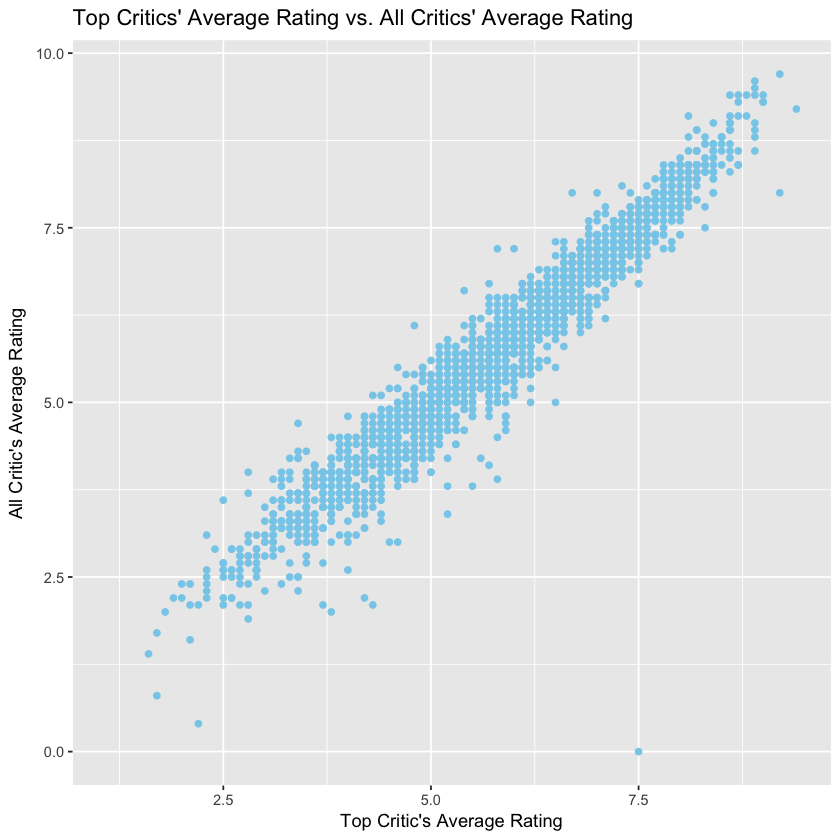

In [11]:
ggplot(MovieTable, aes(y = TopCriticsAverageRating, x =  AllCriticsAverageRating) ) +
  geom_point(na.rm = TRUE, colour = "sky blue")+
  labs(title = "Top Critics' Average Rating vs. All Critics' Average Rating") +
  xlab("Top Critic's Average Rating") +
  ylab("All Critic's Average Rating")

<p>As expected, top critic scores and all critic scores are highly correlated, so they are functionally interchangeable variables. </p>

<p>Now as a quick sanity check, I'd like to make sure that the critics' average rating is correlated with the tomatometer (critics' score). Based on what the tomatometer is (a weighted average of scores), I would expect these two scores to also be highly correlated.</p>

[1] 0.9685098

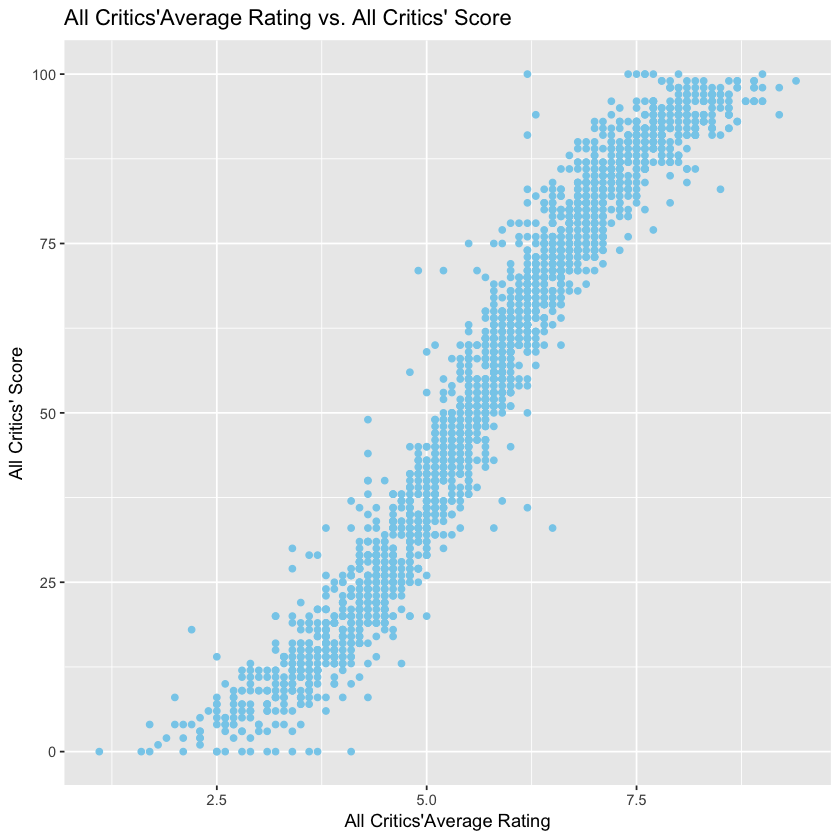

In [12]:
ggplot(MovieTable, aes(y = AllCriticsScore, x =  AllCriticsAverageRating) ) +
  geom_point(na.rm = TRUE, colour = "sky blue")+
  labs(title = "All Critics'Average Rating vs. All Critics' Score") +
  xlab("All Critics'Average Rating") +
  ylab("All Critics' Score")
cor(MovieTable$AllCriticsScore, MovieTable$ AllCriticsAverageRating)

<p> Finally, I'd like to make sure that there's no correlation between the number of reviews counted, and the overall review score. </p>

[1] 0.3851267

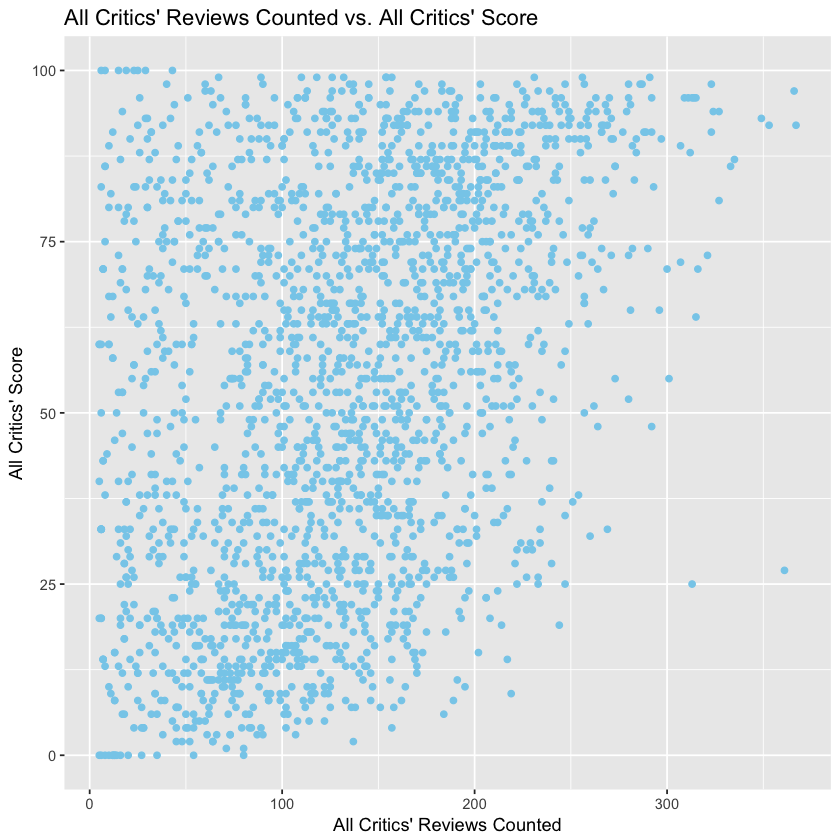

In [13]:
ggplot(MovieTable, aes(y = AllCriticsScore, x = AllCriticsReviewsCounted) ) +
  geom_point(na.rm = TRUE, colour = "sky blue")+
  labs(title = "All Critics' Reviews Counted vs. All Critics' Score") +
  xlab("All Critics' Reviews Counted") +
  ylab("All Critics' Score")
cor(MovieTable$AllCriticsScore, MovieTable$AllCriticsReviewsCounted)

<p> Now that I've done these quick checks, I feel comfortable exploring the distribution of the score difference variable (defined as the difference between the critics' score and the audience score). I will primarily look at the average rating metric because I understand it better than the tomato meter score. </p>

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -6.500  -1.800  -1.000  -1.055  -0.300   2.000 

[1] 1.103588

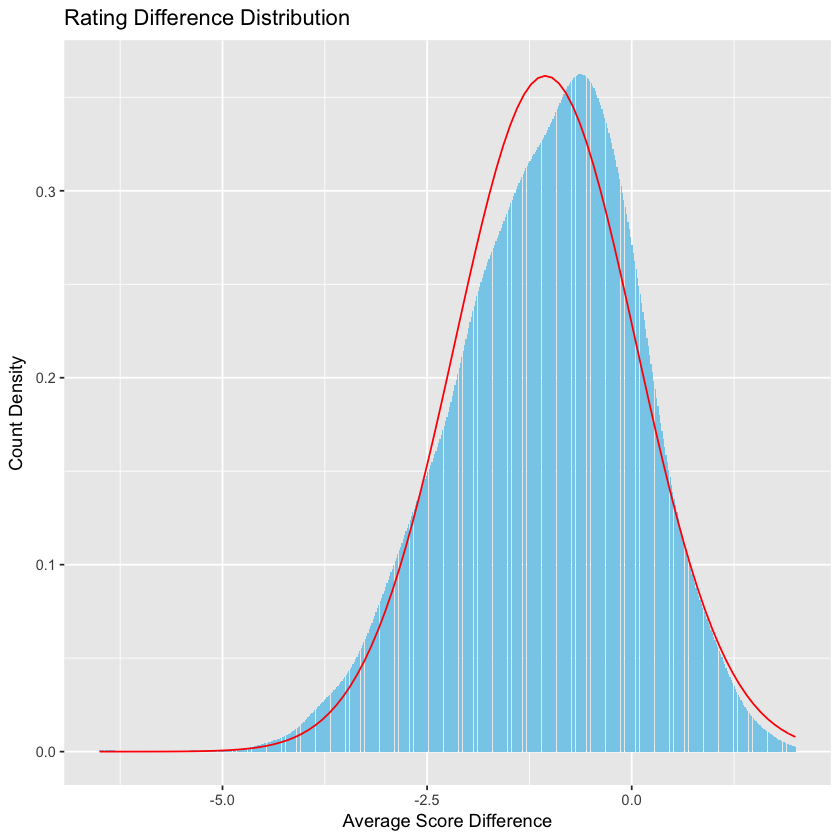

In [14]:
summary(MovieTable$AverageRatingDifference)
sd(MovieTable$AverageRatingDifference)
ggplot(MovieTable) + geom_bar(aes(x = AverageRatingDifference), fill = "sky blue", position = "dodge", 
    stat = "density") + 
    stat_function(fun = dnorm, color = "red", args = list(mean = mean(MovieTable$AverageRatingDifference), 
    sd = sd(MovieTable$AverageRatingDifference)))+
    labs(title = "Rating Difference Distribution") +
    xlab("Average Score Difference") +
    ylab("Count Density")

<p> Looking at the density plot for the rating difference variable, I was pleasantly surprised by how normal the distribution is, and by how tight the variance is. Based on the graph above, it looks like critic ratings are generally one point lower than audience ratings (out of 10) with a standard deviation of 1 point. </p>

<p> Now let's see if we can find some interesting correlations between the average rating difference and any of our other variables.</p>

[1] 0.7533917

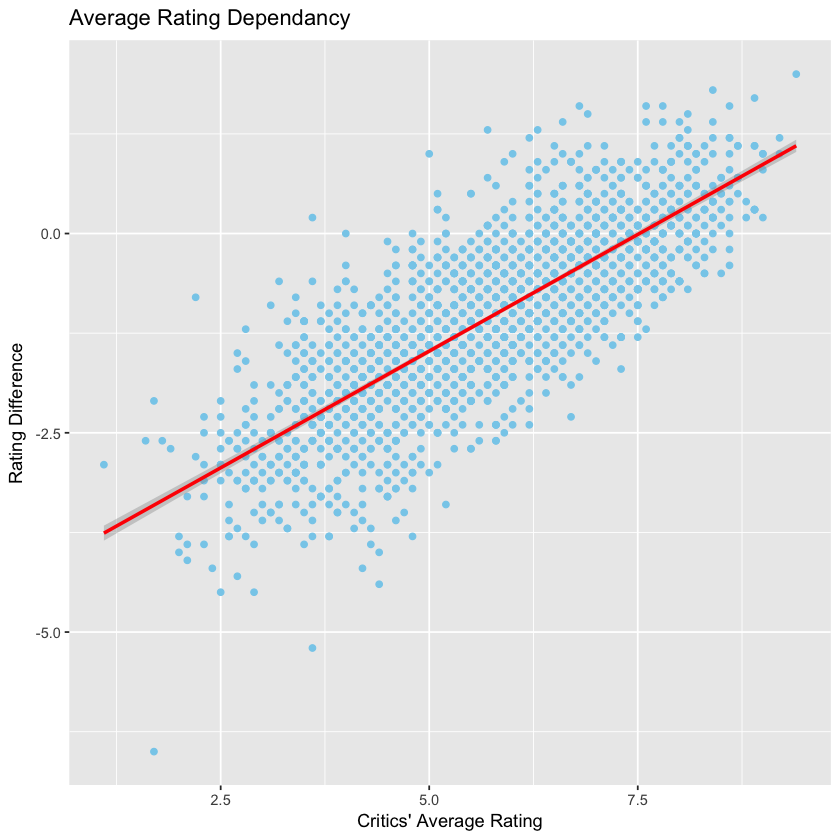

In [15]:
ggplot(MovieTable, aes(y = AverageRatingDifference, x = AllCriticsAverageRating) ) +
  geom_point(colour = "sky blue") + geom_smooth(colour = "red", method=lm)+
  labs(title = "Average Rating Dependancy") +
  xlab("Critics' Average Rating") +
  ylab("Rating Difference")
cor(MovieTable$AllCriticsScore, MovieTable$ScoreDifference)

<p> What's interesting about the graph above is that it seems to imply that there's a tipping point where critical scores become higher than audience scores on average. That is, critics seem to enjoy "very good" movies more than audiences and dislike "very bad" movies more.</p>

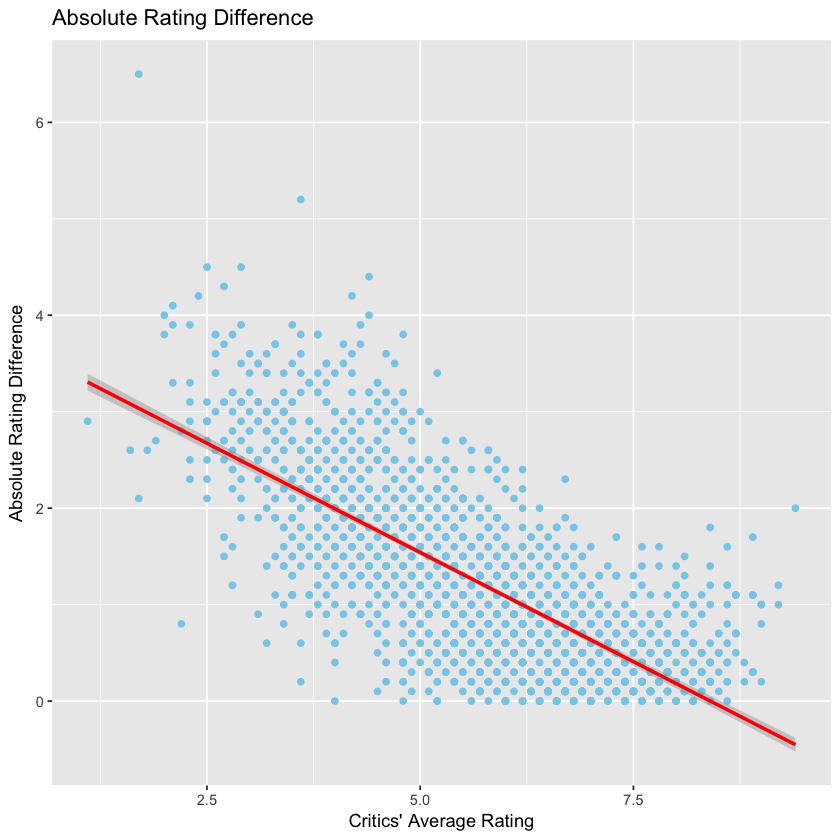

In [16]:
ggplot(MovieTable, aes(y = abs(AverageRatingDifference), x = AllCriticsAverageRating) ) +
  geom_point(colour = "sky blue") + geom_smooth(colour = "red", method=lm)+
  labs(title = "Absolute Rating Difference") +
  xlab("Critics' Average Rating") +
  ylab("Absolute Rating Difference")

<p> Looking at the absolute value of the rating difference (ignoring sign), we also see that critics and audiences diverge more as critical scores go down. So critics and audiences are more in agreement with what makes a good movie than a bad movie.</p>
<p> To explore this further, let's look at the distribution of audience scores and critic scores. </p>

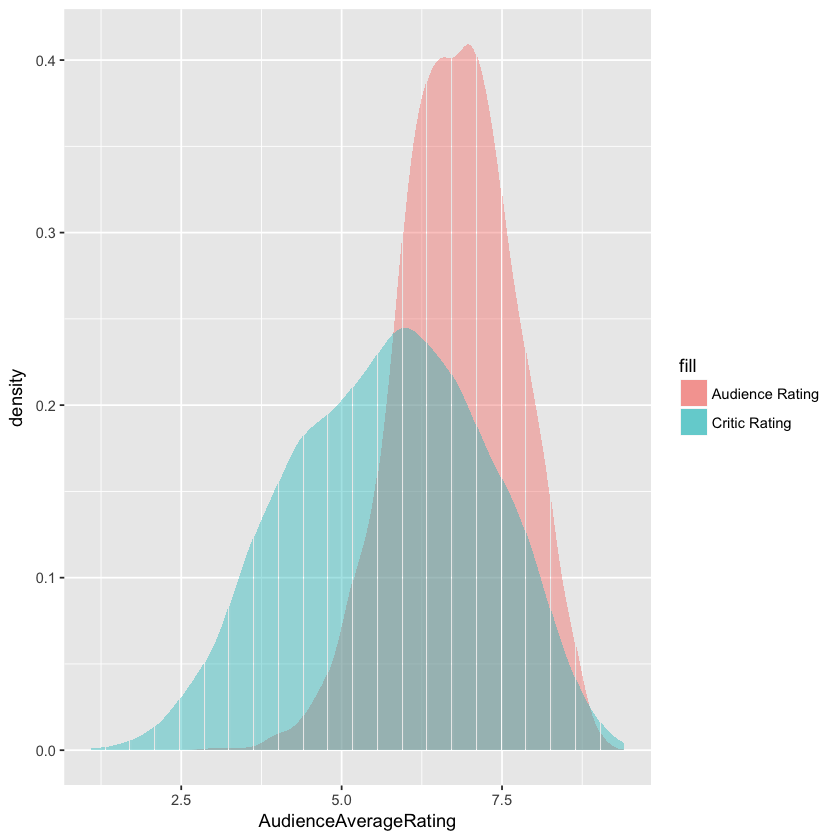

In [17]:
ggplot(MovieTable) + geom_bar(aes(x = AudienceAverageRating, fill = "Audience Rating"), alpha = 0.4, stat = "density") + 
geom_bar(aes(x = AllCriticsAverageRating, fill = "Critic Rating"), alpha = 0.4, stat = "density")  

<p>Here we see that when compared to critics, general audiences are far more likely to give a movie an above average rating. Furthermore, compared to critics, audiences seem far more reluctant to label a movie as bad. In a sense, the distribution of scores between audiences and critics is evidence that critics are better at rating movies than general audiences.</p>
<p>This is very interesting, and if I come back to this problem, I'd like to explore this facet more. But for now, let's move on with our exploration and see how score difference varies with individual movie attributes.</p>

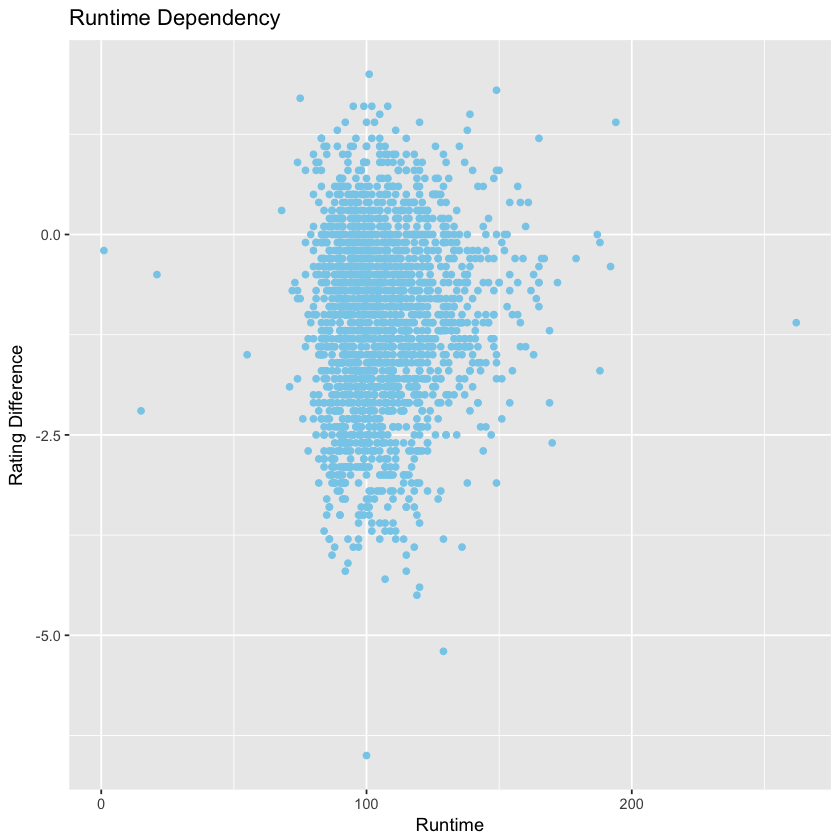

In [18]:
ggplot(MovieTable, aes(y = AverageRatingDifference, x = RunTime) ) +
  geom_point(na.rm = TRUE, colour = "sky blue")+
  labs(title = "Runtime Dependency") +
  xlab("Runtime") +
  ylab("Rating Difference")

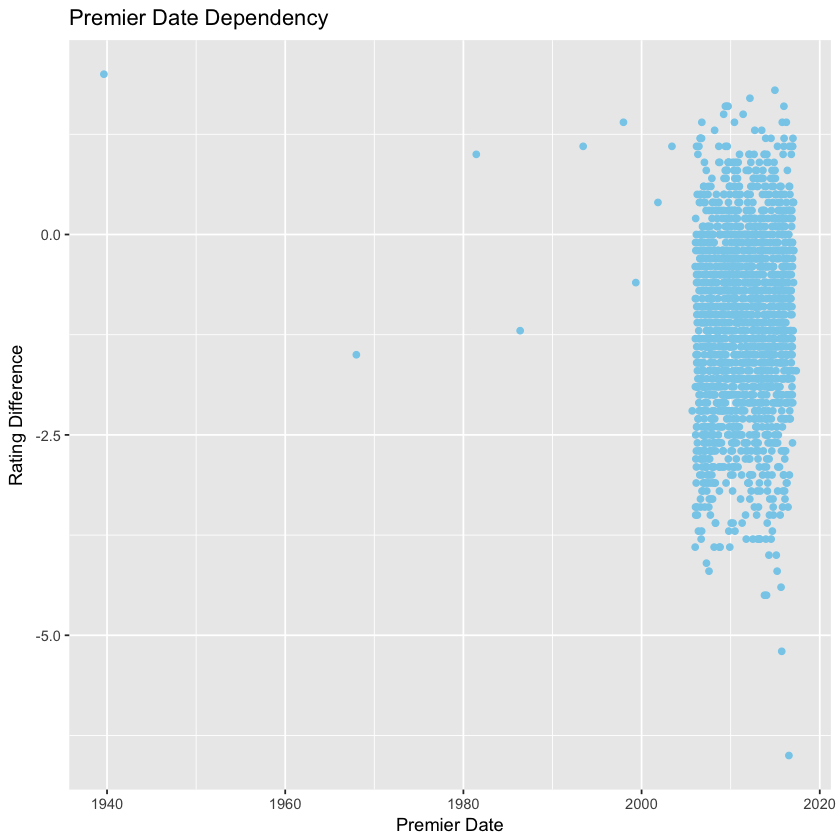

In [19]:
ggplot(MovieTable, aes(y = AverageRatingDifference, x = PremierDate) ) +
  geom_point(na.rm = TRUE, colour = "sky blue")+
  labs(title = "Premier Date Dependency") +
  xlab("Premier Date") +
  ylab("Rating Difference")

<p>Neither the premier date nor the length of the movie seem to have much impact on the score difference between audiences and critics. Which is nice, because it means that audience ratings and critic ratings have remained constant over the last decade</p>

<p> There does seem to be a mild dependency between a movie's genre and it's score difference. </p>

In [24]:
GenreTable = MovieTable[, c(Genres, "AverageRatingDifference") ]
GenreTable = melt(GenreTable, id.vars = c("AverageRatingDifference"))
GenreTable = subset(GenreTable, GenreTable$value == 1)

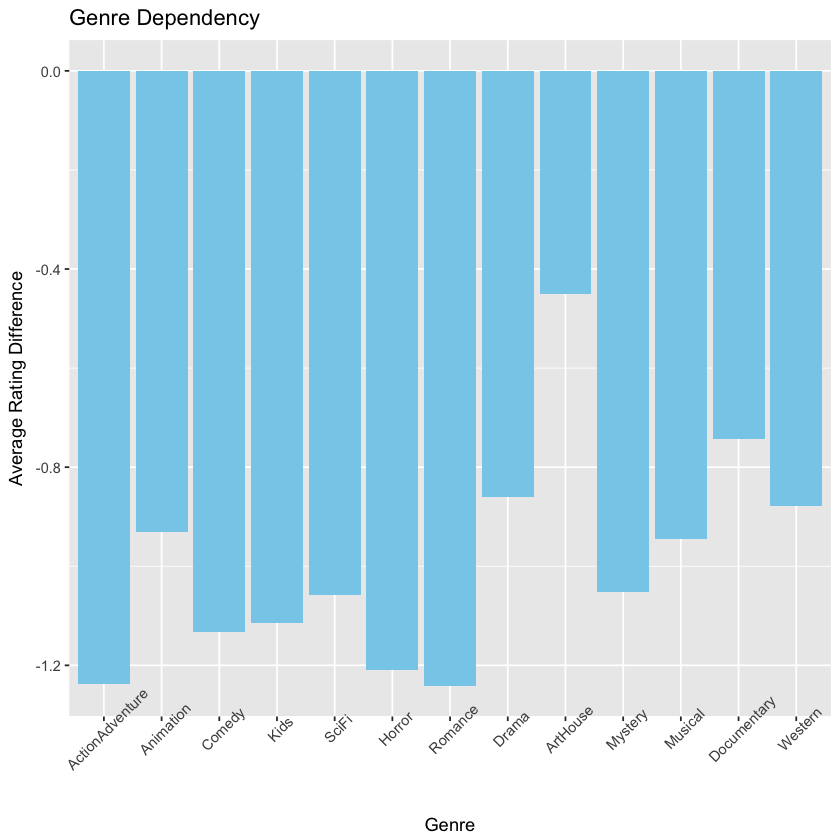

In [25]:
ggplot(GenreTable, aes(x = variable, y = AverageRatingDifference)) + stat_summary(fun.y = mean, 
    geom = "bar", position = position_dodge(1), fill = "sky blue") + theme(axis.text.x = element_text(angle = 45)) + 
    labs(title = "Genre Dependency") + xlab("Genre") + ylab("Average Rating Difference")

<p>But the largest impact seems to appear when we look at score difference against a movies rating (rating as in pg, pg-13, etc).</p>

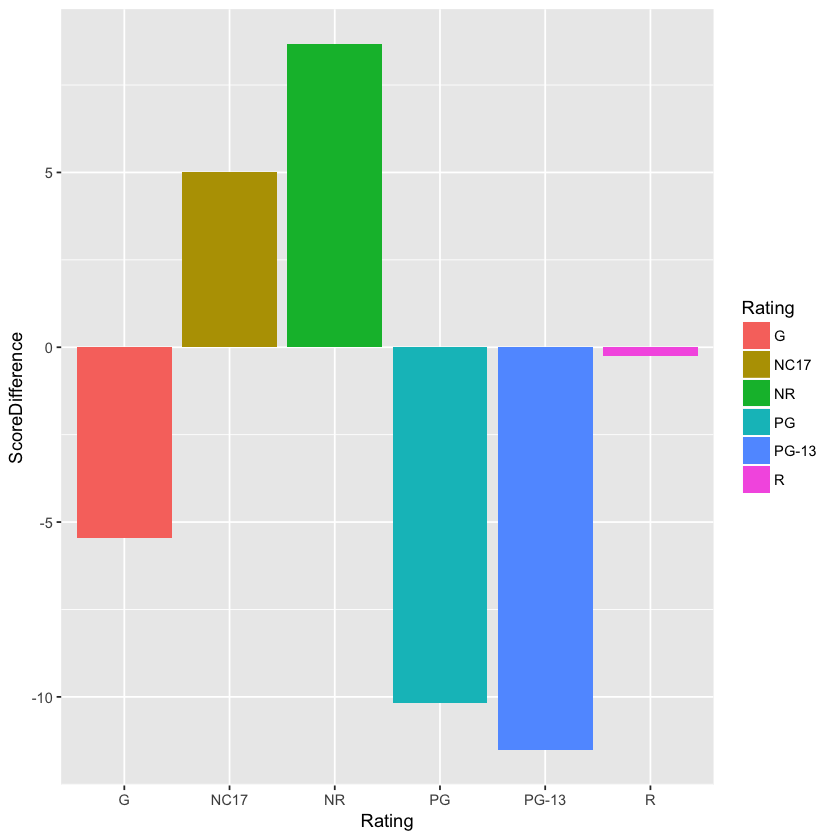

In [26]:
ggplot(MovieTable, aes(y = ScoreDifference, x = Rating, fill=Rating) ) +
  stat_summary(fun.y=mean, geom="bar",position=position_dodge(1))

<p> The preliminary results seem very promising. However, this post is getting rather long. I will continue writing on this in a part 2, where I will expand my data set, do a more formal analysis of the results, and potentially play around with textual analysis, and post a conclusion. Hopefully you found this to be a useful tutorial on culling web data.</p>